<a href="https://colab.research.google.com/github/hector6298/Deep-Learning-Collab-notebooks/blob/master/segmentation_sculptures6k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modified U-net with EfficientNetB7 as the encoder

*   Using ImageDataGenerator
*   Sculptures 6k dataset



This collab is made to train a segmentation model with a custom dataset, not from tensorflow APIs.

Thi line is just to mount your Google Drive. You can skip it if you want.

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Remove useless data from Collab.

In [ ]:
!rm -r /content/sample_data

Download and set raw COCO data

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/sculptures6k/sculptures6k.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/sculptures6k/sculptures6k_segmentations.tar.gz

--2020-08-29 03:41:14--  https://www.robots.ox.ac.uk/~vgg/data/sculptures6k/sculptures6k.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 781175117 (745M) [application/x-gzip]
Saving to: ‘sculptures6k.tar.gz’

sculptures6k.tar.gz 100%[===================>] 744.99M  21.5MB/s    in 35s     

2020-08-29 03:41:51 (21.1 MB/s) - ‘sculptures6k.tar.gz’ saved [781175117/781175117]

--2020-08-29 03:41:51--  https://www.robots.ox.ac.uk/~vgg/data/sculptures6k/sculptures6k_segmentations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15762936 (15M) [application/x-gzip]
Saving to: ‘sculptures6k_segmentations.tar.gz’

sculptures6k_segmen 100%[===================>]  15.03M

Install tensorflow examples to use Pix2Pix for the upsamplers in the decoding part.

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install --upgrade tensorflow-hub

Requirement already up-to-date: tensorflow-hub in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [ ]:
!tar -xvf /content/sculptures6k.tar.gz
!tar -xvf /content/sculptures6k_segmentations.tar.gz

In [ ]:
!rm /content/sculptures6k/train/Rodin_Burghers_of_Calais_0314.jpg
!rm /content/sculptures6k/train/Rodin_Crouching_Woman_0034.jpg
!rm /content/sculptures6k/train/Rodin_Eternal_Idol_0002.jpg

##Python Code

In [ ]:
%matplotlib inline
import os
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_hub as hub

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

#Main Code

## hyperparameters.

In [ ]:
INPUT_SHAPE = (224,224)
EPOCHS = 10
VAL_SUBSPLITS = 5
BATCH_SIZE = 100
LEARNING_RATE = 0.0005
OUTPUT_CHANNELS = 2

Create ImageDataGenerator objects to feed the network

In [ ]:
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     horizontal_flip=True)


In [ ]:
import random
class DataGenerator(keras.utils.Sequence):
  def __init__(self,
               imgPath,
               maskPath,
               is_training=True,
               batch_size=8,
               input_shape=(224,224),
               num_channels = 3,
               shuffle=True,
               augmentationParams=None,
               seed = 3
               ):
    self.batch_size = batch_size
    self.input_shape = input_shape
    self.num_channels = num_channels
    self.shuffle = shuffle
    self.imgPath = imgPath
    self.maskPath = maskPath
    self.imgFiles = os.listdir(imgPath)
    self.maskFiles = os.listdir(maskPath)

    self.imgFiles.sort()
    self.maskFiles.sort()

    self.is_training = is_training
    self.n = 0
    self.seed = seed
    if augmentationParams is not None:
      self.augmentationEngineIMG = ImageDataGenerator(**augmentationParams)
      self.augmentationEngineMASK = ImageDataGenerator(**augmentationParams)
    assert len(self.imgFiles) == len(self.maskFiles), f"Error, both images and mask samples must be equal, but got: {len(self.imgFiles),len(self.maskFiles)} respectively"
      
  def __next__(self):
    batch_x, batch_y = self.__getitem__(self.n)
    self.n += 1
    if self.n >= self.__len__():
      self.on_epoch_end()
      
    return batch_x, batch_y
  
  def __len__(self):
    return int(np.floor(len(self.imgFiles)/float(self.batch_size)))
  
  def reset_batch_index(self):
    self.n = 0

  def on_epoch_end(self):
    self.n = 0

  def __getitem__(self, idx):
    sample_i = self.imgFiles[idx*self.batch_size:(idx+1)*self.batch_size]
    sample_m = self.maskFiles[idx*self.batch_size:(idx+1)*self.batch_size]
    batch_x = np.empty((self.batch_size, self.input_shape[0], self.input_shape[1], self.num_channels), dtype=np.float32)
    batch_y = np.empty((self.batch_size, self.input_shape[0], self.input_shape[1], 1), dtype=np.float32)

    for i in range(self.batch_size):
      img = io.imread(f"{self.imgPath}/{sample_i[i]}")
      mask = io.imread(f"{self.maskPath}/{sample_m[i]}", as_gray=True)
      mask = np.expand_dims(mask, axis=2)
      if(len(img.shape) < 3):
        img = np.expand_dims(img,axis=2)

      #print(mask.shape)
      img = resize(img, self.input_shape)
      mask = resize(mask, self.input_shape)
      #print(mask.shape)
      if self.is_training and hasattr(self,'augmentationEngineIMG'):
        img = self.augmentationEngineIMG.random_transform(img, seed=self.seed)
        mask = self.augmentationEngineMASK.random_transform(mask, seed=self.seed)
   
      batch_x[i] = img
      batch_y[i] = mask
 

    return batch_x, batch_y


In [ ]:
train_generator = DataGenerator("/content/sculptures6k/train",
                                "/content/sculptures6k_segmentations/train",
                                batch_size=BATCH_SIZE,
                                input_shape=INPUT_SHAPE,
                                augmentationParams=data_gen_args
                                )
test_generator = DataGenerator("/content/sculptures6k/test",
                                "/content/sculptures6k_segmentations/test",
                                batch_size=BATCH_SIZE,
                                input_shape=INPUT_SHAPE,
                                augmentationParams=data_gen_args
                                )

##Let's define the model

Install eficcientnet for tensorflow keras

In [ ]:
!pip3 install efficientnet
import efficientnet.tfkeras


     |████████████████████████████████| 51kB 3.7MB/s 


In [ ]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(weights='imagenet', input_shape=(*INPUT_SHAPE,3), include_top=False)

layernames = ["conv1_conv",               #128 channels
              "conv2_block3_preact_relu", #256 channels
              "conv3_block4_preact_relu", #512 channels
              "conv4_block6_preact_relu", #1024 channels
              "post_relu"] #2048 channels   
layers = [base_model.get_layer(name).output for name in layernames]
downsample_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
downsample_stack.trainable = False

upsample_stack = [pix2pix.upsample(1024,3),
                  pix2pix.upsample(512,3),
                  pix2pix.upsample(256,3),
                  pix2pix.upsample(128,3),
                  pix2pix.upsample(64,3)]


In [ ]:
#base_model = tf.keras.applications.resnet_v2.ResNet50V2(weights='imagenet', input_shape=INPUT_SHAPE, include_top=False)

base_model = efficientnet.tfkeras.EfficientNetB0(weights='imagenet', include_top=False, input_shape=[224,224,3])

layernames = ["block1a_project_bn", #(112,112,16)
              "block2b_drop", #(56,56,24)
              "block3b_drop", #(28,28,40)
              "block4c_drop", #(14,14,80) 
              "block6d_drop", #(7,7,192)
              ]   

layers = [base_model.get_layer(name).output for name in layernames]
downsample_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
downsample_stack.trainable = False

upsample_stack = [pix2pix.upsample(96,3),
                  pix2pix.upsample(40,3),
                  pix2pix.upsample(20,3),
                  pix2pix.upsample(12,3),
                  pix2pix.upsample(8,3),
                  ]


In [ ]:
def mod_unet_efficientnet(output_channels, input_shape=[224,224,3]):
  inputs = tf.keras.layers.Input(shape=input_shape)
  x = inputs
  #encoder
  skips = downsample_stack(x)
  #get last of the outputs for bottleneck
  x = skips[-1]
  skips = reversed(skips[:-1])

  #decoder
  it = 0
  for layer_enc, skip in zip(upsample_stack, skips):
    layer_enc.trainable = False
    print(it)
    x = layer_enc(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x,skip])
    
    it += 1

  #last layer

  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, padding='same', name='outMask', trainable=True
  )

  x = last(x)
  #x = tf.keras.activations.softmax(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


Define Our IOU metric before compiling. Default MeanIoU class does not support results from multiple channels that serves as logits

In [ ]:
class meanIoU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = y_pred[..., tf.newaxis]
        return super().update_state(y_true, y_pred, sample_weight=sample_weight)


Instantiate our model and plot the graph.

In [ ]:
model = mod_unet_efficientnet(OUTPUT_CHANNELS)

0
1
2
3


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=[meanIoU(2)])
model.summary()

Model: "functional_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_37 (Functional)      [(None, 112, 112, 64 23564800    input_19[0][0]                   
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 14, 14, 1024) 18878464    functional_37[0][4]              
__________________________________________________________________________________________________
concatenate_52 (Concatenate)    (None, 14, 14, 2048) 0           sequential_14[0][0]              
                                                                 functional_37[0][3]  

##get mask inference methods

In [ ]:
def create_mask_from_inference(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


In [ ]:
def show_predictions(generator=None):
  if generator is not None:
    batch_x, batch_y = next(generator)
    generator.reset_batch_index()
    pred_mask = model.predict(batch_x)
    for i in range(5):
      display([batch_x[i], batch_y[i], create_mask_from_inference(pred_mask[i][tf.newaxis, ...])])
  else:
    display([sample_image, sample_mask,
             create_mask_from_inference(model.predict(sample_image[tf.newaxis, ...]))])


##Show the network is working before training

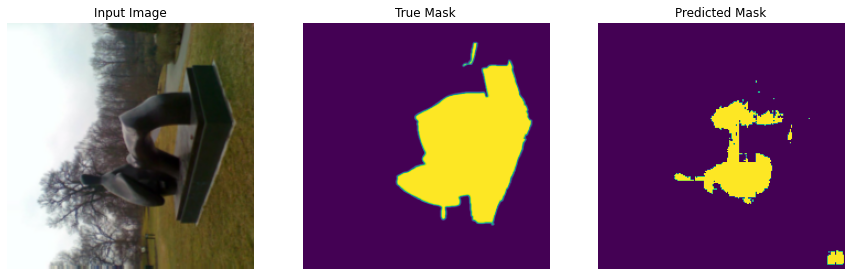

In [ ]:
#train_generator.on_epoch_end()
batch_x, batch_y = next(train_generator)

sample_image, sample_mask = batch_x[20], batch_y[20]
show_predictions()

In [ ]:
sample_mask[sample_mask==1]

array([], dtype=float32)

In [ ]:
pred = model(sample_image[tf.newaxis,...])

In [ ]:
batch_y.shape

(100, 224, 224, 1)

##Training

Do we have prior weights? You can skip this cell if you want.

In [ ]:
if os.path.exists('/content/drive/My Drive/segmentation_net_weights_person26epochs.h5'):
  model.load_weights('/content/drive/My Drive/segmentation_net_weights_person26epochs.h5')


In [ ]:
checkpoint_filepath = '/content/drive/My Drive/tmp/checkpoint2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mean_io_u',
    mode='max',
    save_best_only=True)

Train the model 

In [ ]:
model_history = model.fit(x=train_generator, 
                epochs=10,
                validation_data=test_generator,
                verbose=1,
                callbacks=[model_checkpoint_callback])

Epoch 1/10
31/31 [==============================] - 870s 28s/step - loss: 2.3713 - mean_io_u_13: 0.4857 - val_loss: 1.8680 - val_mean_io_u_13: 0.4827
Epoch 2/10
31/31 [==============================] - 844s 27s/step - loss: 1.7425 - mean_io_u_13: 0.4860 - val_loss: 1.3375 - val_mean_io_u_13: 0.4847
Epoch 3/10
31/31 [==============================] - 833s 27s/step - loss: 1.2453 - mean_io_u_13: 0.4877 - val_loss: 0.9829 - val_mean_io_u_13: 0.4857
Epoch 4/10
31/31 [==============================] - 832s 27s/step - loss: 0.9514 - mean_io_u_13: 0.4883 - val_loss: 0.8263 - val_mean_io_u_13: 0.4857
Epoch 5/10
31/31 [==============================] - 835s 27s/step - loss: 0.8069 - mean_io_u_13: 0.4879 - val_loss: 0.7344 - val_mean_io_u_13: 0.4852
Epoch 6/10
31/31 [==============================] - 828s 27s/step - loss: 0.7382 - mean_io_u_13: 0.4877 - val_loss: 0.7003 - val_mean_io_u_13: 0.4849
Epoch 7/10
31/31 [==============================] - 830s 27s/step - loss: 0.7021 - mean_io_u_13: 0.4

Display training metrics

In [ ]:
def plot_metrics(model_history):

  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  iou = model_history.history['mean_io_u']
  val_iou = model_history.history['val_mean_io_u']
  epochs = range(EPOCHS)
  fig, axs = plt.subplots(2)

  axs[0].plot(epochs, loss, 'r', label='Training loss')
  axs[0].plot(epochs, val_loss, 'bo', label='Validation loss')
  axs[0].title('Training and Validation Loss')
  axs[0].xlabel('Epoch')
  axs[0].ylabel('Loss Value')
  axs[1].plot(epochs, iou, 'r', label='Training iou')
  axs[1].plot(epochs, val_iou, 'bo', label='Validation iou')
  axs[1].title('Training and Validation iou')
  axs[1].xlabel('Epoch')
  axs[1].ylabel('iou Value')
  plt.legend()
  plt.show()



In [ ]:
plot_metrics(model_history)

##Save Model

Save weights after training and network architechture

In [ ]:
json_config = model.to_json()
with open('model_config.json', 'w') as json_file:
    json_file.write(json_config)
model.save_weights('drive/My Drive/segmentation_net_weights_sculptures.h5')
